In [1]:
class Dodo:
    def __init__(self, reserves: list, liq_param: float):
        self.reserves = reserves
        self.reserves_regressed = reserves
        self.liq_param = liq_param

    def spot_price(
        self,
        asset_in_ix: int = 0,
        asset_out_ix: int = 1,
        oracle_price: float = 1
    ):
        if self.reserves[asset_in_ix] >= self.reserves_regressed[asset_in_ix]:
            exchange_rate = oracle_price*(1+self.liq_param*(
                (self.reserves_regressed[asset_out_ix]/ self.reserves[asset_out_ix])**2-1))
        else:
            exchange_rate = oracle_price/(1+self.liq_param*
                                          ((self.reserves_regressed[asset_in_ix]/ self.reserves[asset_in_ix])**2-1))
        return exchange_rate

    def _compute_trade_qty_out(
        self, qty_in: int, asset_in_ix: int, asset_out_ix: int, oracle_price: float
    ):
        pre_trade_reserves_in_ix = self.reserves[asset_in_ix]
        pre_trade_reserves_out_ix = self.reserves[asset_out_ix]

        reserves_regressed_in_ix = self.reserves_regressed[asset_in_ix]
        reserves_regressed_out_ix = self.reserves_regressed[asset_out_ix]

        updated_reserves_in_ix = pre_trade_reserves_in_ix + qty_in
        
        diff = reserves_regressed_in_ix - updated_reserves_in_ix 
        part_1 = oracle_price*reserves_regressed_out_ix*(1-2*self.liq_param)
        part_2 = (1-self.liq_param)
        
        if updated_reserves_in_ix >= reserves_regressed_in_ix:
            updated_reserves_out_ix = (diff+part_1+(
                (diff+part_1)**2+4*self.liq_param*part_2*
                                                    (oracle_price*reserves_regressed_out_ix)**2)**(1/2))/(2*oracle_price*part_2)
        else: 
            updated_reserves_out_ix = reserves_regressed_out_ix + (diff*(self.liq_param*diff+updated_reserves_in_ix))/(oracle_price*updated_reserves_in_ix)
        
        return updated_reserves_in_ix, updated_reserves_out_ix


    def trade(
        self, qty_in: int, asset_in_ix: int, asset_out_ix: int, oracle_price: float
    ):
        pre_trade_reserves_out_ix = self.reserves[asset_out_ix]

        updated_reserves_in_ix, updated_reserves_out_ix = self._compute_trade_qty_out(
            qty_in, asset_in_ix, asset_out_ix, oracle_price
        )
        self.reserves[asset_in_ix] = updated_reserves_in_ix
        self.reserves[asset_out_ix] = updated_reserves_out_ix
        return pre_trade_reserves_out_ix - self.reserves[asset_out_ix]

    def slippage(
        self, qty_in: int, asset_in_ix: int, asset_out_ix: int, oracle_price: float
    ):
        x_1 = qty_in
        _, r_2_prime = self._compute_trade_qty_out(
            qty_in, asset_in_ix, asset_out_ix, oracle_price
        )
        x_2 = self.reserves[asset_out_ix] - r_2_prime

        p = self.spot_price(asset_in_ix, asset_out_ix, oracle_price)
        return (x_1 / x_2) / p - 1



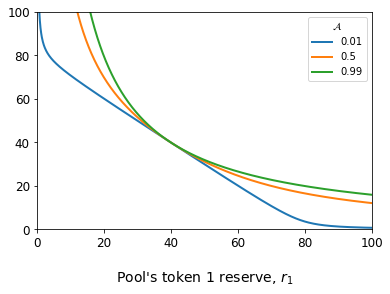

In [2]:
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
import numpy as np
import os

X1 = 40
X2 = 40 

oracle_price = 1

DP18 = 1e18
LABELPAD = 20
FONTSIZE = 14
LABELSIZE = 12

dodo_A_001 = Dodo([X1, X2], 0.01)
dodo_A_05 = Dodo([X1, X2], 0.5)
dodo_A_099 = Dodo([X1, X2], 0.99)

dodo_A_001_example = []
dodo_A_05_example = []
dodo_A_099_example = []

# 0.99 and 0.1 make no sense, smart contracts use integer mathematics
# we have this hack here, for continuity of the plots
domain = np.arange(-0.9999999 * X1, 5.1 * X1, 0.1)
# trade and look at reserves

for x in domain:
    dodo_A_001_example.append(dodo_A_001._compute_trade_qty_out(x, 0, 1, oracle_price))
    dodo_A_05_example.append(dodo_A_05._compute_trade_qty_out(x, 0, 1, oracle_price))
    dodo_A_099_example.append(dodo_A_099._compute_trade_qty_out(x, 0, 1, oracle_price))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot([x[0] for x in dodo_A_001_example], [x[1] for x in dodo_A_001_example], linewidth=2)
ax.plot([x[0] for x in dodo_A_05_example], [x[1] for x in dodo_A_05_example], linewidth=2)
ax.plot([x[0] for x in dodo_A_099_example], [x[1] for x in dodo_A_099_example], linewidth=2)
ax.tick_params(axis="x", labelsize=LABELSIZE)
ax.tick_params(axis="y", labelsize=LABELSIZE)
ax.set_xlabel(
    r"Pool's token 1 reserve, $r_1$",
    labelpad=LABELPAD,
    size=FONTSIZE,
)
ax.set_ylim([0, 100])
ax.set_xlim([0, 100])
ax.legend(["0.01", "0.5", "0.99"], title=r"$\mathcal{A}$")  

fig.savefig("C:/Users/simon/Desktop/UCL_DeFi/BondingCurves/plots/conservation_dodo.pdf", bbox_inches='tight')

<ipython-input-1-cae004963053>:41: RuntimeWarning: divide by zero encountered in double_scalars
  updated_reserves_out_ix = reserves_regressed_out_ix + (diff*(self.liq_param*diff+updated_reserves_in_ix))/(oracle_price*updated_reserves_in_ix)


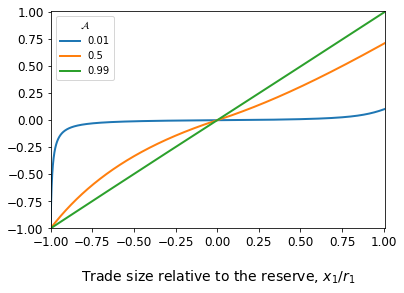

In [9]:
X1 = 40
X2 = 40 

oracle_price = 1

DP18 = 1e18
LABELPAD = 20
FONTSIZE = 14
LABELSIZE = 12


dodo_A_001 = Dodo([X1, X2], 0.01)
dodo_A_05 = Dodo([X1, X2], 0.5)
dodo_A_099 = Dodo([X1, X2], 0.99)

dodo_A_001_example = []
dodo_A_05_example = []
dodo_A_099_example = []

slippage_domain = np.arange(-1 * X1, 2 * X1, 0.0001)

for qty_in in slippage_domain:
    dodo_A_001_example.append(dodo_A_001.slippage(qty_in, 0, 1, oracle_price))
    dodo_A_05_example.append(dodo_A_05.slippage(qty_in, 0, 1, oracle_price))
    dodo_A_099_example.append(dodo_A_099.slippage(qty_in, 0, 1, oracle_price))


fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot([x / X1 for x in slippage_domain],dodo_A_001_example,linewidth=2,)
ax.plot([x / X1 for x in slippage_domain],dodo_A_05_example,linewidth=2,)
ax.plot([x / X1 for x in slippage_domain],dodo_A_099_example,linewidth=2,)
ax.set_xlabel(
    r"Trade size relative to the reserve, $x_1 / r_1$",
    labelpad=LABELPAD,
    size=FONTSIZE,
)
ax.set_ylim([-1.0, 1.01])
ax.set_xlim([-1.0, 1.01])
ax.tick_params(axis="x", labelsize=LABELSIZE)
ax.tick_params(axis="y", labelsize=LABELSIZE)
ax.legend(["0.01", "0.5", "0.99"], title=r"$\mathcal{A}$")  


fig.savefig("C:/Users/simon/Desktop/UCL_DeFi/BondingCurves/plots/slippage_dodo.pdf", bbox_inches='tight')

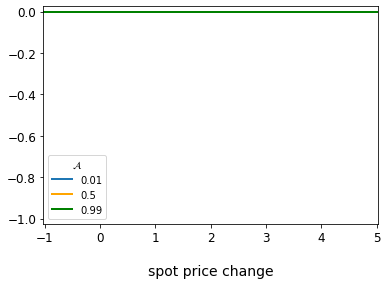

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel("spot price change", labelpad=LABELPAD, size=FONTSIZE)
ax.set_xlim([-1.025, 5.025])
ax.set_ylim([-1.025, 0.025])
ax.axhline(y=0, linewidth=2)
ax.axhline(y=0, linewidth=2, c='orange')
ax.axhline(y=0, linewidth=2, c='g')
ax.tick_params(axis="x", labelsize=LABELSIZE)
ax.tick_params(axis="y", labelsize=LABELSIZE)
ax.legend(["0.01", "0.5", "0.99"], title=r"$\mathcal{A}$") 

fig.savefig("C:/Users/simon/Desktop/UCL_DeFi/BondingCurves/plots/divloss_dodo.pdf", bbox_inches='tight')